In [1]:
import os

experiment_path = './data/Map Experiment #3'

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [2]:
from map_maker import cluttered_map, save_map
from Turtlebot_Kinematics import unicycleKin
from environment import Environment, load_ENV
from Runner import ControllMode, Runner
from pso_controller import Multi_PSO_Controller
from dwa_controller import DWA_Controller

kinematic = unicycleKin()
run_len = 31
dt = 0.1
max_index = None

# map parameters
map_obs = 8
map_size = 50
map_unknown = False
map_name = f"cluttered_{map_obs}obs_{map_size}x{map_size}_{'unknown' if map_unknown else 'known'}"

for i in range(run_len):
    run_path = f"{experiment_path}/{i}"
    if not os.path.exists(run_path):
        os.makedirs(run_path)

    run_map = cluttered_map(map_obs, map_size, map_unknown)
    map_path = f"{run_path}/{map_name}"
    save_map(run_map, map_name, run_path)


    MultiPSO_ENV = Environment.from_dict(run_map, kinematic, record=True)
    MultiPSO_controller = Multi_PSO_Controller(10, kinematic, 5, 1.5, 10)
    if max_index is None:
        max_index = MultiPSO_ENV.goal_travel_time / dt + 200
    else: assert max_index == MultiPSO_ENV.goal_travel_time / dt + 200
    MultiPSO_Runner = Runner(
        MultiPSO_ENV, 
        ControllMode.MultiPSO, 
        MultiPSO_controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/MultiPSO_data"
    )
    MultiPSO_Runner.loop()

    DWA_ENV = Environment.from_dict(run_map, kinematic, record=True)
    DWA_controller = DWA_Controller(20, kinematic, virtual_dt=2.0)
    DWA_Runner = Runner(
        DWA_ENV, 
        ControllMode.DWA, 
        DWA_controller, 
        max_step = max_index,
        dt = dt,
        save_path= f"{run_path}/DWA_data"
    )
    DWA_Runner.loop()


pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
# 1
fit=280.4305325834315 | [14.55649375 -0.34445565]
pop_avg: 21.863
chr_avg: 23.566
__call__ 0.14813494682312012
# 2
fit=238.01139609673316 | [15.         -0.46670316]
pop_avg: 24.938
chr_avg: 23.068
__call__ 0.15213823318481445
# 3
fit=285.8644748640043 | [15.         -0.45305211]
pop_avg: 24.47
chr_avg: 19.067
__call__ 0.14718079566955566
# 4
fit=300.8467693926606 | [14.57039935 -0.35140729]
pop_avg: 27.696
chr_avg: 20.07
__call__ 0.15862226486206055
# 5
fit=341.68630985803185 | [14.87762826 -0.36521266]
pop_avg: 25.883
chr_avg: 21.089
__call__ 0.15113496780395508
# 6
fit=368.2586832335377 | [14.91806407 -0.37338309]
pop_avg: 22.61
chr_avg: 18.617
__call__ 0.1511378288269043
# 7
fit=356.2384607032958 | [14.91580615 -0.30254801]
pop_avg: 22.952
chr_avg: 17.973
__call__ 0.1511375904083252
# 8
fit=423.26997654251113 | [14.96292948 -0.42219462]
pop_avg: 19.932
chr_avg: 19.5

In [3]:
import numpy as np

max_index = int(np.ceil(max_index))
print("Max_index:", max_index)


Max_index: 566


In [4]:
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt

In [5]:
def fill_df(df, length, di):
    index = df.index[-1]
    last_loc = df.iloc[-1]
    while len(df) < length:
        index += di
        df.loc[index] = last_loc
    return df

def build_loc(goal_dists, obst_dists):
    return {
        "goal_dists": goal_dists,
        "obst_dists": obst_dists
    }

In [6]:

Multi_PSO_df = DataFrame(columns=["goal_dists", "obst_dists"])
DWA_df = DataFrame(columns=["goal_dists", "obst_dists"])

def append_to_total_df(total_df, file_name, max_index, dt):
    df = pandas.read_hdf(file_name)
    goal_dists = fill_df(df["goal_dist"], max_index, dt)
    obst_dists = fill_df(df["obst_dist"], max_index, dt)
    total_df.loc[i] = build_loc(goal_dists, obst_dists)

for i in range(run_len):
    append_to_total_df(Multi_PSO_df, f"{experiment_path}/{i}/MultiPSO_data.h5", max_index, dt)
    append_to_total_df(DWA_df, f"{experiment_path}/{i}/DWA_data.h5", max_index, dt)
    



In [10]:
import numpy as np

def get_eval_arrays(total_df, max_index):
    print(total_df.iloc[0])
    avg_goal = list([np.average([total_df.iloc[i]["goal_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    avg_obst = list([np.average([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    min_obst = list([np.min([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    return avg_goal, avg_obst, min_obst


goal_dists    0.0      0.000000
0.1      0.066942
0.2      0...
obst_dists    0.0     3.125000
0.1     3.214131
0.2     3.30...
Name: 0, dtype: object
goal_dists    0.0       0.000000
0.1       0.131812
0.2     ...
obst_dists    0.0     3.125000
0.1     3.218463
0.2     3.31...
Name: 0, dtype: object


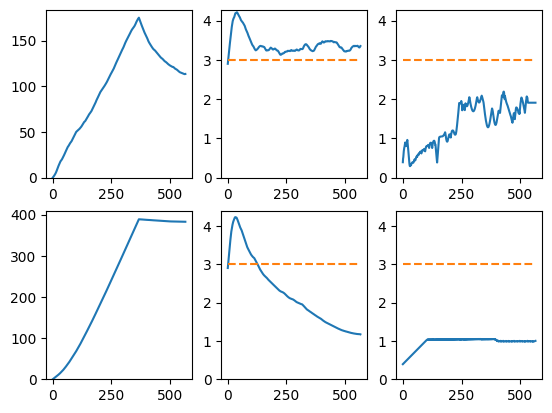

In [11]:
def plot_eval_row(axs, total_df):
    avg_goal, avg_obst, min_obst = get_eval_arrays(total_df, max_index)
    axs[0].plot(avg_goal)
    axs[1].plot(avg_obst)
    axs[1].plot([3]*len(avg_obst), linestyle="--")
    axs[2].plot(min_obst) 
    axs[2].plot([3]*len(min_obst), linestyle="--")
    axs[2].set_ylim(top = axs[1].get_ylim()[1])
    for ax in axs:
        ax.set_ylim(bottom = 0.0)

fig, axs = plt.subplots(2,3)
plot_eval_row(axs[0], Multi_PSO_df)
plot_eval_row(axs[1], DWA_df)


In [9]:
df = pandas.read_hdf("data\Map Experiment #2\9\DWA_data.h5")
print(df)
max_index

          robo_x      robo_y  robo_deg      goal_x  goal_y   goal_dist  \
0.0    50.000000  300.000000  0.000000   50.000000   300.0    0.000000   
0.1    51.542745  299.996242 -0.004872   51.363636   300.0    0.179148   
0.2    53.018691  299.999993 -0.009533   52.727273   300.0    0.291418   
0.3    54.449510  300.010400 -0.014051   54.090909   300.0    0.358752   
0.4    55.960577  300.028028 -0.018823   55.454545   300.0    0.506807   
...          ...         ...       ...         ...     ...         ...   
56.3  279.024862  305.335500 -0.226861  550.000000   300.0  271.027660   
56.4  279.102567  305.357246 -0.134841  550.000000   300.0  270.950400   
56.5  279.183546  305.364430 -0.227553  550.000000   300.0  270.869579   
56.6  279.258533  305.385340 -0.138776  550.000000   300.0  270.795021   
56.7  279.340058  305.392869 -0.232144  550.000000   300.0  270.713663   

      obst_dist  
0.0    3.125000  
0.1    3.221422  
0.2    3.313668  
0.3    3.403094  
0.4    3.497536  
...

566